# Лабораторная работа №4

ФИО:  **Селифонов Артём Евгеньевич**
Группа: **БИВТ-20-1**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

In [56]:
!pip install -q datasets

from datasets import load_dataset

dataset = load_dataset('Matthijs/snacks') 

  0%|          | 0/3 [00:00<?, ?it/s]

In [57]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

In [58]:
labels = dataset["test"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    print(i, label)
    label2id[label] = i
    id2label[i] = label

0 apple
1 banana
2 cake
3 candy
4 carrot
5 cookie
6 doughnut
7 grape
8 hot dog
9 ice cream
10 juice
11 muffin
12 orange
13 pineapple
14 popcorn
15 pretzel
16 salad
17 strawberry
18 waffle
19 watermelon


In [59]:
type(dataset['train'][1]['image'])

PIL.JpegImagePlugin.JpegImageFile

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [61]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):
        
      self.input_data = input_data
      # Transform input data
      self.transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

  def __len__(self):
      return len(self.input_data)
    
  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])
  
  def get_labels(self, idx):
      return self.input_data[idx]['label']
  
  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

# Шаги 1-3

#### snacks


In [62]:
train_dataset = ImageDataset(dataset["train"])
test_dataset = ImageDataset(dataset["test"])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = dataset["test"].features["label"].names
dataset_sizes = {
    'train': len(dataset['train']),
    'test': len(dataset['test']),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

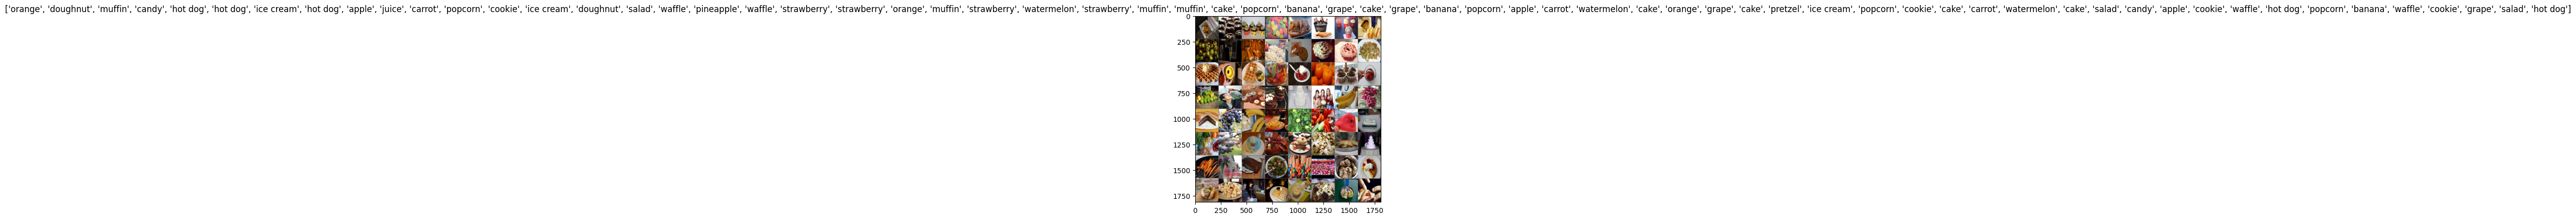

In [63]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    #mean = np.array([0.5, 0.5, 0.5])
    #std = np.array([0.5, 0.5, 0.5])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [64]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader
            if phase == 'test':
                current_dataloader = test_dataloader


            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if ((phase == 'test') & (epoch_acc > best_acc)):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.ELU(),
    nn.Conv2d(16, 32, 3),
    nn.ELU(),
    nn.Conv2d(32, 32, 3, 3, 2),

    nn.Conv2d(32, 32, 3),
    nn.ELU(),
    nn.Conv2d(32, 32, 3),
    nn.ELU(),
    nn.Conv2d(32, 32, 3, 3, 3),

    nn.Conv2d(32, 32, 3),
    nn.Conv2d(32, 64, 3, 3, 3),

    nn.Conv2d(64, 64, 3),
    nn.Conv2d(64, 64, 3, stride=(2, 1), padding=(4, 2)),

    nn.Flatten(),

    nn.Linear(4032, 512),
    nn.Linear(512, 512),
    nn.ELU(),
    nn.Linear(512, 512),
    nn.Linear(512, 20),
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer_ft = Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.9839 Acc: 0.0697
test Loss: 2.9967 Acc: 0.0525

Epoch 1/9
----------
train Loss: 2.9416 Acc: 0.0831
test Loss: 2.9367 Acc: 0.0903

Epoch 2/9
----------
train Loss: 2.9121 Acc: 0.0907
test Loss: 2.9053 Acc: 0.0872

Epoch 3/9
----------
train Loss: 2.8627 Acc: 0.1023
test Loss: 2.7688 Acc: 0.1208

Epoch 4/9
----------
train Loss: 2.8369 Acc: 0.1114
test Loss: 2.8378 Acc: 0.1218

Epoch 5/9
----------


In [66]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    output = model_fitted(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [67]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

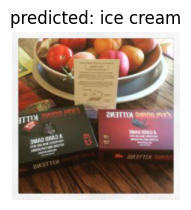

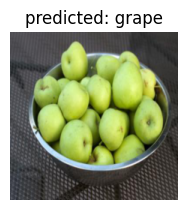

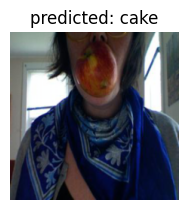

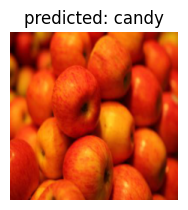

In [68]:
visualize_model(model_fitted, 4)

grape


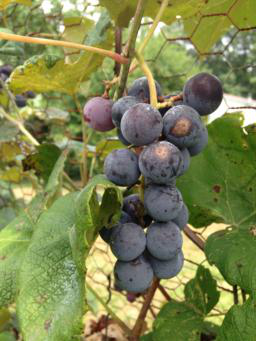

In [69]:
num = 350
print(predict(dataset['test'][num]['image']))
dataset['test'][num]['image']

#Предобученный на ImageNet ResNet-18

In [70]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 20)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [71]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.3756 Acc: 0.3652
test Loss: 1.5303 Acc: 0.6544

Epoch 1/9
----------
train Loss: 1.1913 Acc: 0.7255
test Loss: 0.9642 Acc: 0.7532

Epoch 2/9
----------
train Loss: 0.8747 Acc: 0.7997
test Loss: 0.9481 Acc: 0.7595

Epoch 3/9
----------
train Loss: 0.8449 Acc: 0.8072
test Loss: 0.9119 Acc: 0.7689

Epoch 4/9
----------
train Loss: 0.8206 Acc: 0.8152
test Loss: 0.9097 Acc: 0.7815

Epoch 5/9
----------
train Loss: 0.8216 Acc: 0.8148
test Loss: 0.9150 Acc: 0.7668

Epoch 6/9
----------
train Loss: 0.8133 Acc: 0.8179
test Loss: 0.9104 Acc: 0.7710

Epoch 7/9
----------
train Loss: 0.8187 Acc: 0.8165
test Loss: 0.9166 Acc: 0.7710

Epoch 8/9
----------
train Loss: 0.8214 Acc: 0.8162
test Loss: 0.8999 Acc: 0.7752

Epoch 9/9
----------
train Loss: 0.8185 Acc: 0.8142
test Loss: 0.9128 Acc: 0.7700

Training complete in 8m 5s
Best val Acc: 0.781513


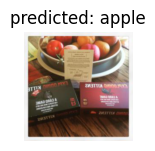

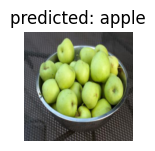

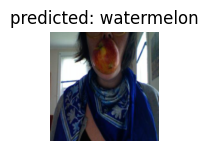

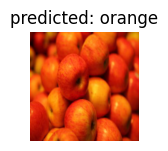

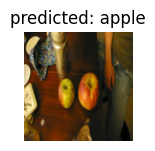

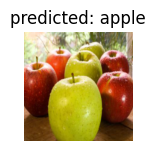

In [72]:
visualize_model(model_ft)

In [31]:
model_conv = torchvision.models.r
a(pretrained=True)

num_ftrs = model_conv.fc.in_features
# по умолчанию requires_grad = True
model_conv.fc = nn.Linear(num_ftrs, 20)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.6199 Acc: 0.2733
test Loss: 2.1236 Acc: 0.5011

Epoch 1/4
----------
train Loss: 1.8509 Acc: 0.5761
test Loss: 1.6135 Acc: 0.6145

Epoch 2/4
----------
train Loss: 1.5786 Acc: 0.6602
test Loss: 1.5613 Acc: 0.6387

Epoch 3/4
----------
train Loss: 1.5403 Acc: 0.6726
test Loss: 1.5492 Acc: 0.6376

Epoch 4/4
----------
train Loss: 1.5230 Acc: 0.6693
test Loss: 1.5381 Acc: 0.6397

Training complete in 3m 22s
Best val Acc: 0.672592


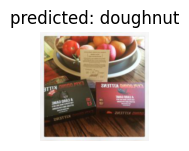

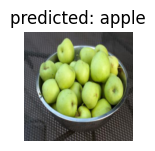

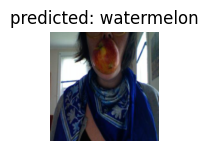

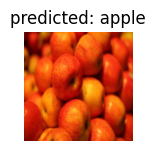

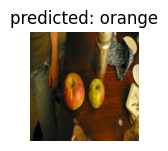

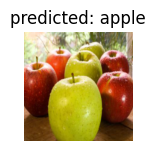

In [33]:
visualize_model(model_conv)